In [1]:
import json
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.core.interactiveshell import InteractiveShell
from tensorflow import keras
from tqdm import tqdm

from src.data_utils import ImageLoader, PairsGenerator, train_val_split
from src.utils import (
    compute_val_dcg,
    euclidean_distance,
    loss,
    make_callbacks,
    plot_history,
    save_params,
    save_submission,
)

InteractiveShell.ast_node_interactivity = "all"

In [2]:
class CFG:
    def __init__(
        self,
    ):
        self.seed = 39
        self.batch_size = 32
        self.img_size = (512, 81)
        self.n_channels = None
        self.fold = 0
        self.norm = False
        self.pos_label = 0
        self.emb_len = 1024
        self.kernel_size = 3
        self.act_fn = "relu"
        self.batch_norm = True
        self.n_epochs = 150
        self.center_crop = False
        self.input_shape = (
            self.img_size
            if self.n_channels is None
            else (*self.img_size, self.n_channels)
        )


cfg = CFG()

In [3]:
root_dir = "/app/_data/artist_data/"
mod_dir = f"/app/_data/artist_data/models/contr_loss_fold_{cfg.fold}/"
shutil.rmtree(mod_dir)
os.makedirs(mod_dir, exist_ok=True)

In [4]:
train = pd.read_csv(os.path.join(root_dir, "train_meta.tsv"), sep="\t")
test = pd.read_csv(os.path.join(root_dir, "test_meta.tsv"), sep="\t")

## train_val_split

In [5]:
train_df, val_df = train_val_split(df=train, fold=cfg.fold, seed=cfg.seed)

## DataGenerator

In [6]:
train_gen = PairsGenerator(
    df=train_df,
    img_loader=ImageLoader(
        target_size=cfg.img_size,
        augment=True,
        center_crop=cfg.center_crop,
        norm=cfg.norm,
        n_channels=cfg.n_channels,
    ),
    batch_size=cfg.batch_size,
    shuffle=True,
    positive_label=cfg.pos_label,
)
val_gen = PairsGenerator(
    df=val_df,
    img_loader=ImageLoader(
        target_size=cfg.img_size,
        augment=False,
        center_crop=cfg.center_crop,
        norm=cfg.norm,
        n_channels=cfg.n_channels,
    ),
    batch_size=cfg.batch_size,
    shuffle=True,
    positive_label=cfg.pos_label,
)

## Model

In [7]:
def embNet(cfg):
    input = tf.keras.Input(shape=cfg.input_shape, dtype="float32")
    x = keras.layers.Conv1D(
        cfg.input_shape[0],
        cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_1",
    )(input)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[0],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_2",
    )(x)
    x = keras.layers.AveragePooling1D(pool_size=2, name="avg_pool_1")(x)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[0],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_3",
    )(x)

    x = keras.layers.Conv1D(
        filters=cfg.input_shape[0],
        kernel_size=cfg.kernel_size,
        activation=cfg.act_fn,
        name="Conv1D_4",
    )(x)
    x = keras.layers.AveragePooling1D(pool_size=2, name="avg_pool_2")(x)
    x = keras.layers.Flatten(name="flatten")(x)
    x = keras.layers.Dense(cfg.emb_len, activation="relu", name=f"dense_{cfg.emb_len}")(
        x
    )
    return keras.Model(inputs=input, outputs=x, name="embedding")

In [8]:
class SiamNet:
    def __init__(self, embedding_net):
        self.embedding_net = embedding_net
        self.model = self.build_model()

    def build_model(self):
        input_1 = keras.layers.Input(self.embedding_net.input_shape[1:], name="img1")
        input_2 = keras.layers.Input(self.embedding_net.input_shape[1:], name="img2")
        node1 = self.embedding_net(input_1)
        node2 = self.embedding_net(input_2)

        merge_layer = keras.layers.Lambda(
            euclidean_distance, name="euclidean_distance"
        )([node1, node2])
        normal_layer = keras.layers.BatchNormalization(name="final_bn")(merge_layer)
        output = keras.layers.Dense(1, activation="sigmoid", name="final_dense")(
            normal_layer
        )
        model = keras.Model(inputs=[input_1, input_2], outputs=output)
        return model

In [9]:
sNet = SiamNet(embedding_net=embNet(cfg))
model = sNet.model

In [10]:
callbacks = make_callbacks(
    path=mod_dir,
    monitor="val_loss",
    mode="min",
    reduce_patience=5,
    stop_patience=21,
)
model.compile(
    loss=loss(1),
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()],
)

## Train

In [11]:
history = model.fit(
    x=train_gen,
    epochs=cfg.n_epochs,
    verbose="auto",
    callbacks=callbacks,
    validation_data=val_gen,
    shuffle=True,
    steps_per_epoch=train_gen.__len__(),
    validation_steps=val_gen.__len__(),
    validation_freq=1,
    max_queue_size=10,
    workers=10,
)

Epoch 1/150
504/504 [==============================] - ETA: 0s - loss: 0.2148 - accuracy: 0.7719 - precision: 0.7972 - recall: 0.7302
Epoch 1: val_loss improved from inf to 0.19798, saving model to /app/_data/artist_data/models/contr_loss_fold_0/best.h5
504/504 [==============================] - 109s 205ms/step - loss: 0.2148 - accuracy: 0.7719 - precision: 0.7972 - recall: 0.7302 - val_loss: 0.1980 - val_accuracy: 0.7535 - val_precision: 0.6827 - val_recall: 0.9424 - lr: 1.0000e-04
Epoch 2/150
503/504 [============================>.] - ETA: 0s - loss: 0.2022 - accuracy: 0.8055 - precision: 0.8223 - recall: 0.7771
Epoch 2: val_loss improved from 0.19798 to 0.18532, saving model to /app/_data/artist_data/models/contr_loss_fold_0/best.h5
504/504 [==============================] - 107s 208ms/step - loss: 0.2022 - accuracy: 0.8057 - precision: 0.8225 - recall: 0.7771 - val_loss: 0.1853 - val_accuracy: 0.8264 - val_precision: 0.7801 - val_recall: 0.9193 - lr: 1.0000e-04
Epoch 3/150
504/504 

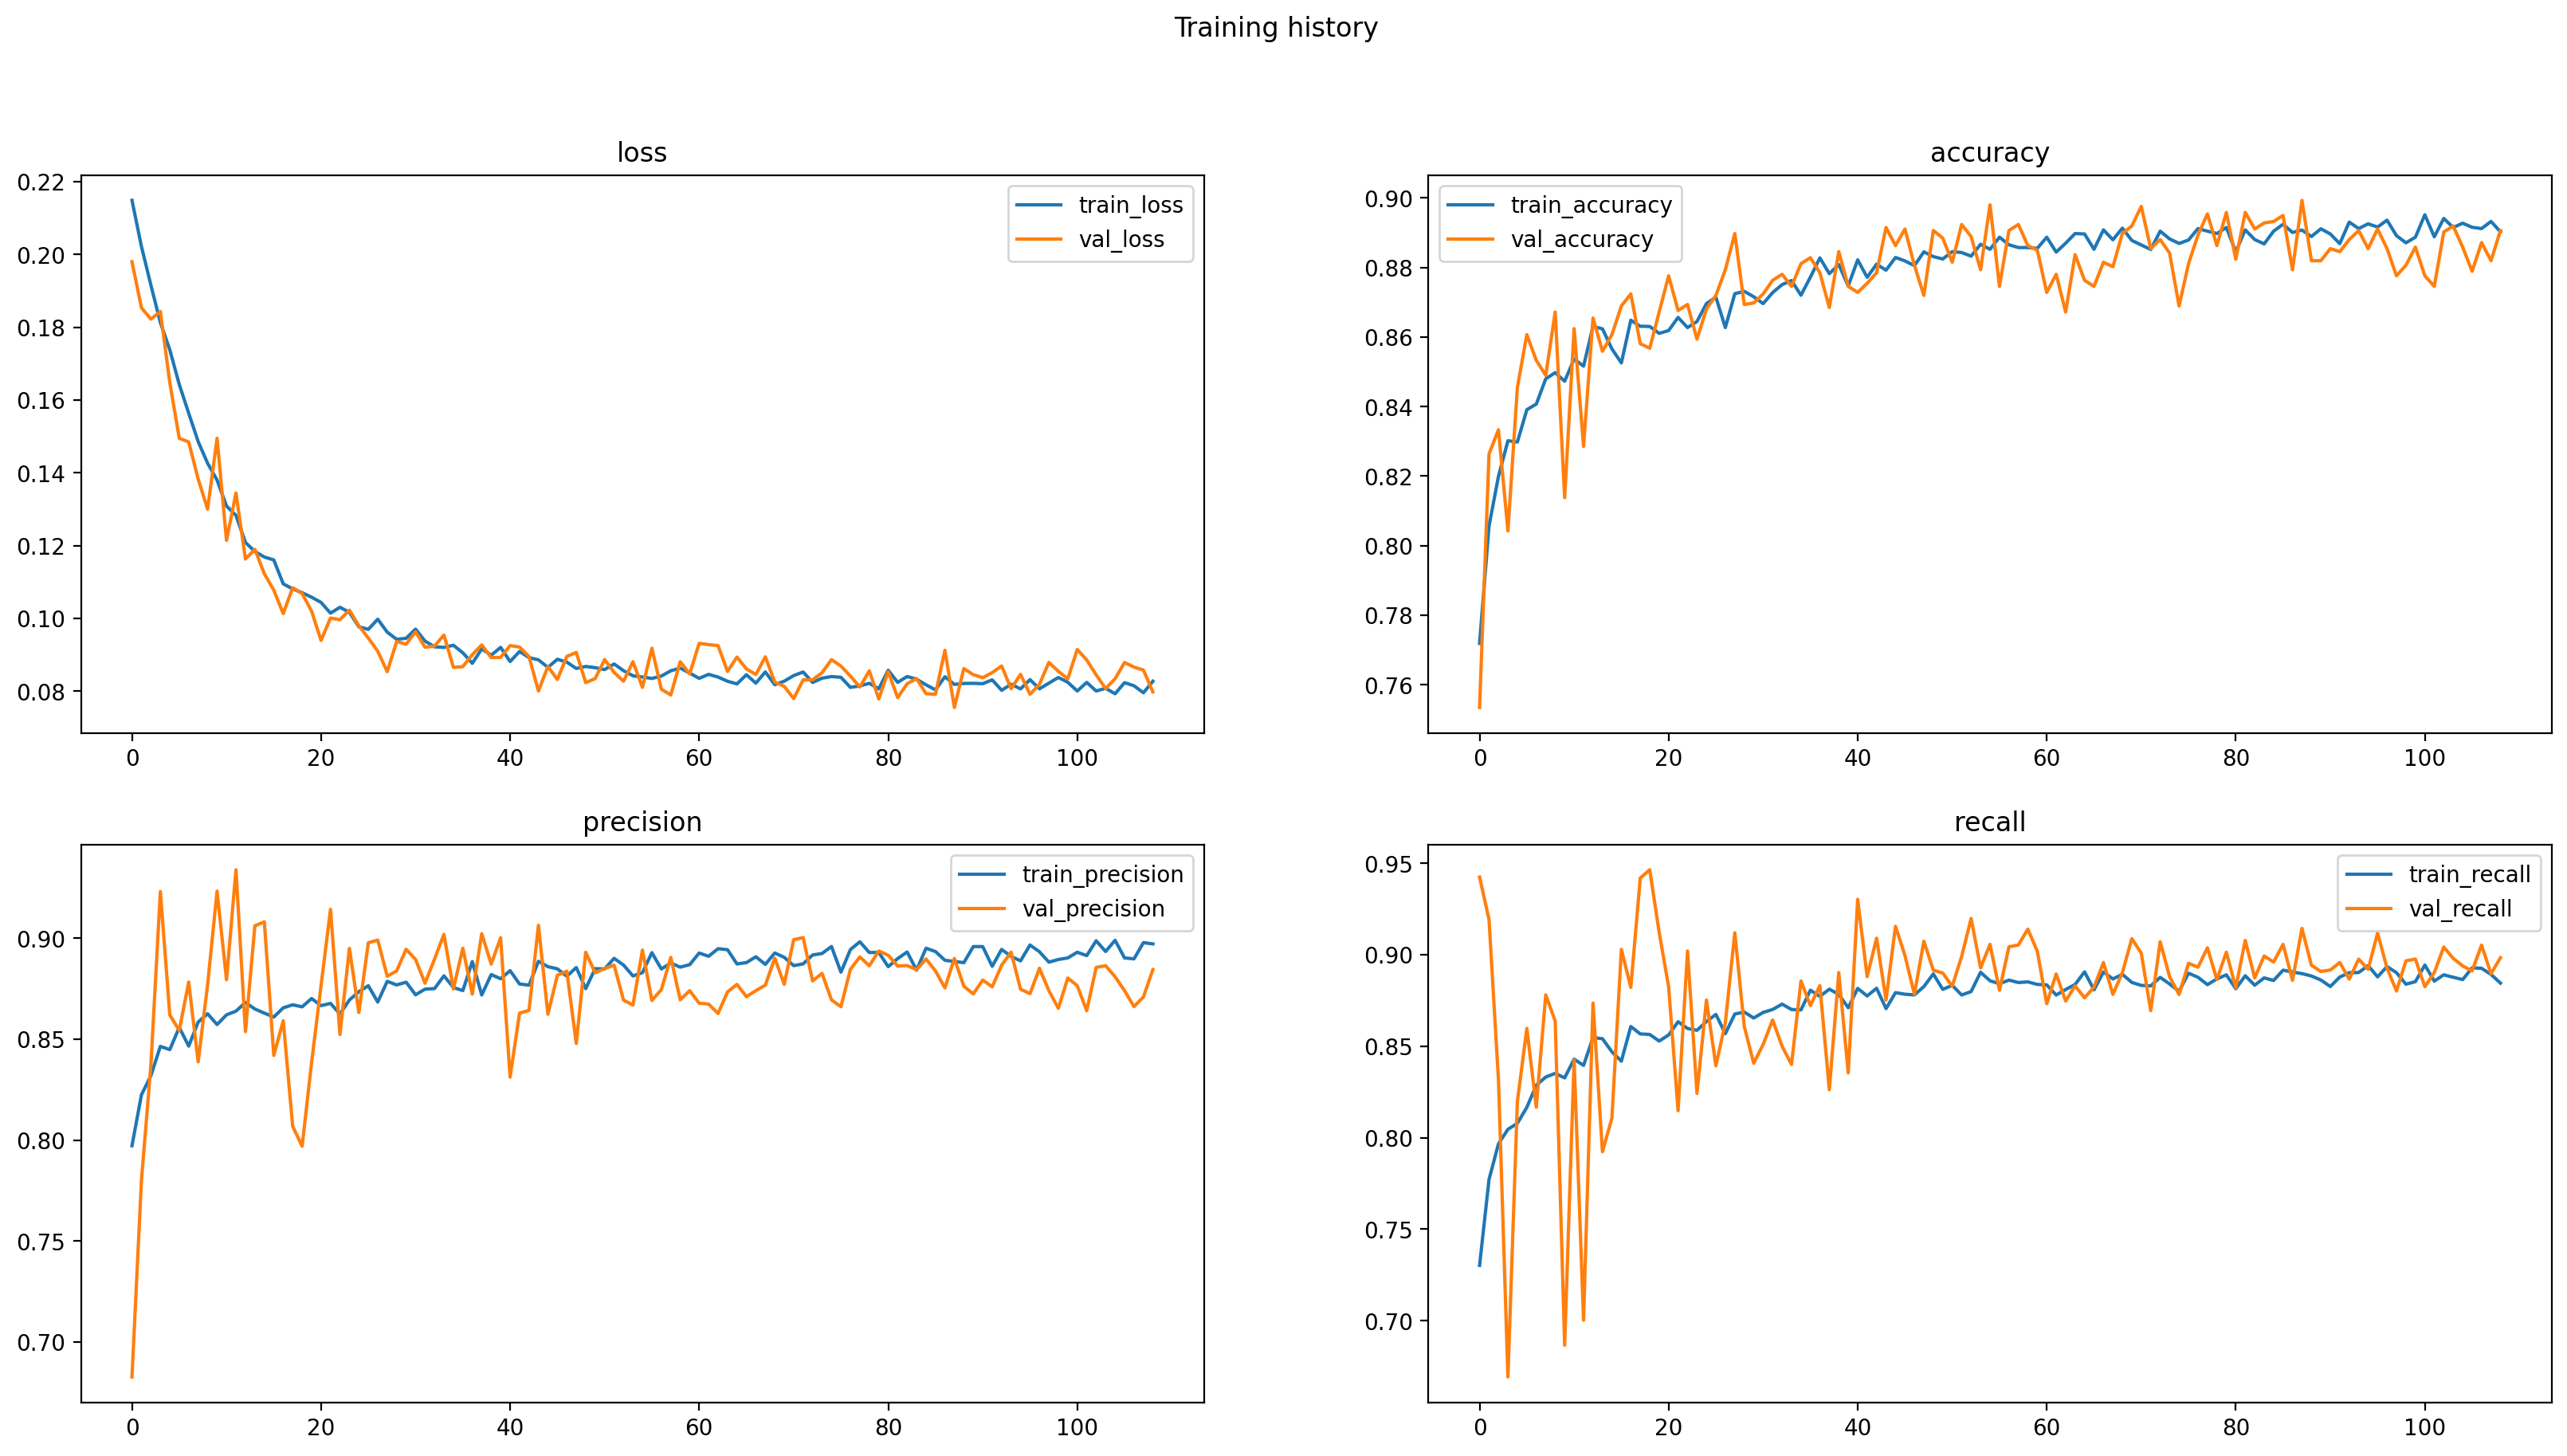

In [12]:
plot_history(history.history)

In [13]:
emb_model = [x for x in model.layers if x.name == "embedding"][0]
compute_val_dcg(emb_model, val_df, cfg, "euclidean")

Making prediction
1000/1000 [==============================] - 3s 2ms/step

Computing ranked list


100% 1000/1000 [00:00<00:00, 4500.14it/s]
100% 1000/1000 [00:00<00:00, 1631.89it/s]



Calculating NDCG


100% 1000/1000 [00:00<00:00, 3927.95it/s]


NDCG on val set = 0.43189


## Save model, history and params

In [14]:
save_params(
    mod_dir, emb_model, history, cfg, loss_name="contrastive_loss", metric="acc"
)


Max_acc = 0.8993055820465088, model saved to /app/_data/artist_data/models/contr_loss_fold_0/model_899.h5


## Test

In [15]:
save_submission(
    model=emb_model,
    test_df=test,
    cfg=cfg,
    submission_path=mod_dir,
    annoy_metric="angular",
    top_size=100,
    annoy_num_trees=256,
)

Making prediction
41377/41377 [==============================] - 101s 2ms/step

Computing ranked list


100% 41377/41377 [00:08<00:00, 4708.98it/s]
100% 41377/41377 [02:17<00:00, 301.88it/s]



Submission file saved to /app/_data/artist_data/models/contr_loss_fold_0/submission_100.txt
